In [1]:
pip install pandas numpy arch scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 8.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from arch import arch_model
from scipy.stats import norm
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv("../Clean Data/US_Cleaned.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1101 entries, 0 to 1100
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1101 non-null   object 
 1   PX_LAST      1101 non-null   float64
 2   PX_VOLUME_x  1101 non-null   int64  
 3   VIX          1101 non-null   float64
 4   SOFR3M       1101 non-null   float64
 5   PX_BID       1101 non-null   float64
 6   PX_VOLUME_y  1101 non-null   float64
 7   PX_ASK       1101 non-null   float64
 8   PX_SPREAD    1101 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 77.5+ KB


In [10]:
def black_scholes_call(S, K, T, r, sigma):
    """
    Calculate the Black-Scholes option price.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T ) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    C = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return C
def black_scholes_put(S, K, T, r, sigma):
    """
    Calculate Black-Scholes put option price.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T ) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    P = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return P

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

df['Log_Returns'] = np.log(df['PX_LAST'] / df['PX_LAST'].shift(1))
df = df.dropna()  # Remove any NaN values resulting from shift operation

model = arch_model(
    df['Log_Returns'],
    vol='Garch',
    p=1,
    q=1,
    dist='normal',
    rescale=False,
    x=df[['PX_VOLUME_x']]
    )
model_fit = model.fit(disp="off")
df['GARCH_Volatility'] = model_fit.conditional_volatility

df['Sigma_Annualized'] = df['GARCH_Volatility'] * np.sqrt(252)
df['Daily_STIR'] = df['SOFR3M']/252

df['S'] = df['PX_LAST']              # Spot price (index price on that day)
df['K'] = df['PX_LAST']              # Set strike price equal to spot price (ATM option)
df['T'] = 1/252                      # Time to expiry (1 day in years)
df['r'] = df['Daily_STIR']               # Daily short-term interest rate (SOFR3M)
df['Sigma'] = df['GARCH_Volatility'] # Use annualized GARCH volatility as sigma

df['Call_Price'] = df.apply(
    lambda row: black_scholes_call(row['S'], row['K'], row['T'], row['r'], row['Sigma']), axis=1
    )
df['Put_Price'] = df.apply(
    lambda row: black_scholes_put(row['S'], row['K'], row['T'], row['r'], row['Sigma']), axis=1
    )

df['Theoretical_Spread'] = (df['Call_Price'] + df['Put_Price']) / 2

df_Model = (df[['Date', 'PX_LAST', 'GARCH_Volatility', 'Sigma_Annualized', 'VIX', 'SOFR3M', 'Daily_STIR', 'Theoretical_Spread',]])
df_Model.info()
df_Model.to_csv("../Data Model/US_Model.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 1096 entries, 1095 to 0
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                1096 non-null   datetime64[ns]
 1   PX_LAST             1096 non-null   float64       
 2   GARCH_Volatility    1096 non-null   float64       
 3   Sigma_Annualized    1096 non-null   float64       
 4   VIX                 1096 non-null   float64       
 5   SOFR3M              1096 non-null   float64       
 6   Daily_STIR          1096 non-null   float64       
 7   Theoretical_Spread  1096 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 77.1 KB


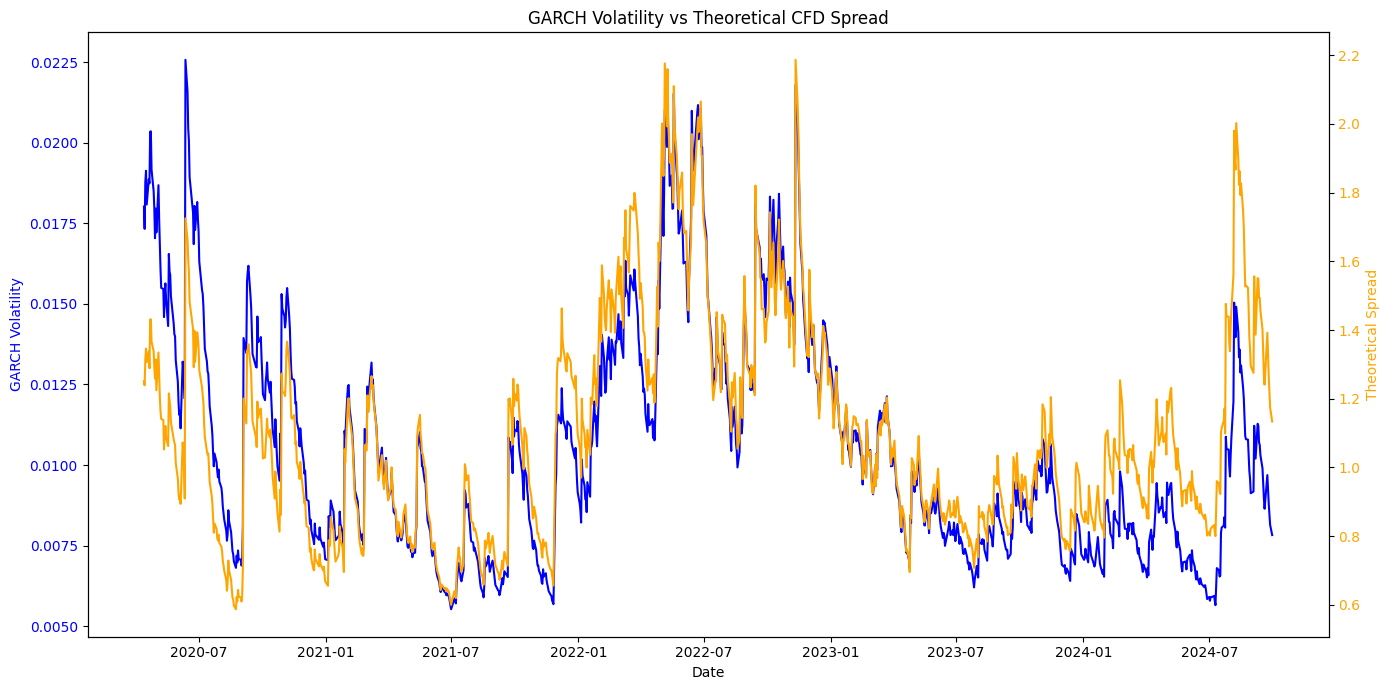

In [21]:
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.plot(df['Date'], df['GARCH_Volatility'], color='b', label='GARCH Volatility')
ax1.set_xlabel('Date')
ax1.set_ylabel('GARCH Volatility', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(df['Date'], df['Theoretical_Spread'], color='orange', label='Theoretical Spread')
ax2.set_ylabel('Theoretical Spread', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('GARCH Volatility vs Theoretical CFD Spread')
fig.tight_layout()

plt.show()